# NLP Final Project - Sentiment Analysis

For this final project, there is a collection of ~200K news articles on our favorite topics, data science, machine learning, and artificial intelligence. Our task is to identify what industries and job lines are going to be most impacted by AI over the next several years, based on the information/insights you can extract from this text corpus.

Goal: provide actionable recommendations on what can be done with AI to automate the jobs, improve employee productivity, and generally make AI adoption successful. Please pay attention to the introduction of novel technologies and algorithms, such as AI for image generation and Conversational AI, as they represent the entire paradigm shift in adoption of AI technologies and data science in general.


In [ ]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer, RobertaForSequenceClassification
import logging
logging.basicConfig(level=logging.ERROR)
from transformers import AdamW


### Fine Tuning Roberta for Sentiment Analysis
https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb

Using this dataset from kaggle:https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news

In [ ]:
# !pip install transformers simpletransformers nltk

In [ ]:
import os
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer, DistilBertForSequenceClassification, DistilBertTokenizer
from datasets import load_dataset
import torch
import torch.nn as nn


### Loading data

In [ ]:
# Load the topic labeled file
# file_path = '/content/drive/My Drive/nlp_final/all-data.csv'

df = pd.read_csv('all-data.csv', header=None, encoding='latin1')

# Display loaded data
df.head()

,0,1
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
new_column_names = {
    0: 'label',
    1: 'phrase'
}

# Use the rename method
df.rename(columns=new_column_names, inplace=True)

In [ ]:
df.shape

(4846, 2)

In [ ]:
df.isnull().sum()

label     0
phrase    0
dtype: int64

In [ ]:
df['label'].value_counts()

neutral     2879
positive    1363
negative     604
Name: label, dtype: int64

In [ ]:
# Create a mapping dictionary
sentiment_mapping = {
    "neutral": 1,
    "positive": 2,
    "negative": 0
}

# Apply the mapping
df['label'] = df['label'].map(sentiment_mapping)

df.head()

,label,phrase
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


### Preparing Dataset

In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [ ]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['phrase']
        self.targets = self.data['label']
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer(
            text, 
            max_length=self.max_len, 
            padding='max_length', 
            truncation=True, 
            return_tensors='pt'
        )

        ids = inputs['input_ids'].squeeze()
        mask = inputs['attention_mask'].squeeze()

        return {
            'input_ids': ids,
            'attention_mask': mask,
            'labels': torch.tensor(self.targets[index], dtype=torch.long)  # Ensure labels are long
        }

In [ ]:
# Setting up the device for GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device
model.to(device)


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
# Define your training function
def train(epoch):
    model.train()
    for batch in training_loader:
        inputs = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

In [ ]:
# Initialize tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_size = 0.8
train_data=df.sample(frac=train_size,random_state=200)
test_data=df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (4846, 2)
TRAIN Dataset: (3877, 2)
TEST Dataset: (969, 2)


In [ ]:
training_loader = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
evaluation_loader = DataLoader(testing_set, batch_size=VALID_BATCH_SIZE, shuffle=False)

### Fine-tuning

In [ ]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)


/home/ubuntu/.local/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import torch
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Define your training function with step-wise accuracy and loss calculation
def train(epoch):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    step_loss = 0
    step_correct = 0
    steps = 0

    for step, batch in enumerate(tqdm(training_loader), start=1):
        inputs = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Compute predictions
        predictions = torch.argmax(logits, dim=-1)

        # Update correct predictions and total samples
        correct = (predictions == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)
        step_correct += correct

        # Backpropagation and optimization step
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        step_loss += loss.item()

        # Print metrics every 5000 steps
        if step % 5000 == 0:
            step_avg_loss = step_loss / 5000
            step_accuracy = step_correct / (5000 * labels.size(0))
            print(f"{step}it [{tqdm.format_interval(tqdm(step * training_loader.batch_size / len(training_loader)))}] "
                  f"Training Loss per 5000 steps: {step_avg_loss:.4f}")
            print(f"Training Accuracy per 5000 steps: {step_accuracy * 100:.2f}%")
            step_loss = 0
            step_correct = 0

    # Calculate average loss and accuracy for the epoch
    avg_loss = total_loss / len(training_loader)
    accuracy = total_correct / total_samples

    print(f"The Total Accuracy for Epoch {epoch}: {accuracy * 100:.2f}%")
    print(f"Training Loss Epoch: {avg_loss:.4f}")
    print(f"Training Accuracy Epoch: {accuracy * 100:.2f}%")

    return avg_loss, accuracy

In [ ]:
EPOCHS = 2
for epoch in range(EPOCHS):
    train(epoch)

100%|██████████| 485/485 [01:13<00:00,  6.62it/s]


The Total Accuracy for Epoch 0: 60.61%
Training Loss Epoch: 0.9064
Training Accuracy Epoch: 60.61%


100%|██████████| 485/485 [01:14<00:00,  6.54it/s]

The Total Accuracy for Epoch 1: 81.35%
Training Loss Epoch: 0.4749
Training Accuracy Epoch: 81.35%


### Training on larger dataset since accuracy is pretty low
https://huggingface.co/datasets/eengel7/sentiment_analysis_training

#### Loading data

In [45]:
from datasets import load_dataset
import pandas as pd

# Replace with the path to your local Parquet file
parquet_file_path = 'train.parquet'

# Load the dataset
dataset = load_dataset('parquet', data_files=parquet_file_path)

# Convert to Pandas DataFrame
df = pd.DataFrame(dataset)

# Normalize the nested dictionary into separate columns
df_expanded = pd.json_normalize(df['train'])

# Display the new DataFrame
df_expanded.head()

,Sentiment,Headline,Headline_string
0,1,"[139, 4693, 4, 107, 341, 43, 228, 3877, 4, 637...","According to Gran , the company has no plans t..."
1,1,"[1389, 107, 64, 1007, 152, 1269, 276, 34, 1008...",Technopolis plans to develop in stages an area...
2,0,"[371, 326, 106, 4, 660, 1959, 1390, 153, 1567,...",The international electronic industry company ...
3,2,"[8, 43, 121, 4, 148, 61, 463, 221, 110, 61, 44...",With the new production plant the company woul...
4,2,"[139, 4, 1270, 411, 13, 47, 1504, 592, 304, 28...",According to the company 's updated strategy f...


In [47]:
new_df = df_expanded[['Sentiment', 'Headline_string']]

In [48]:
new_column_names = {
    'Sentiment': 'label',
    'Headline_string': 'phrase'
}

# Use the rename method
new_df.rename(columns=new_column_names, inplace=True)

/usr/lib/python3/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [49]:
new_df.shape

(11500, 2)

In [50]:
new_df.isnull().sum()

label     0
phrase    0
dtype: int64

In [51]:
new_df['label'].value_counts()

0    4328
1    4023
2    3149
Name: label, dtype: int64

In [8]:
# # Create a mapping dictionary
# sentiment_mapping = {
#     "neutral": 1,
#     "positive": 2,
#     "negative": 0
# }

,label,phrase
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


#### Preparing Dataset

In [52]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [53]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['phrase']
        self.targets = self.data['label']
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer(
            text, 
            max_length=self.max_len, 
            padding='max_length', 
            truncation=True, 
            return_tensors='pt'
        )

        ids = inputs['input_ids'].squeeze()
        mask = inputs['attention_mask'].squeeze()

        return {
            'input_ids': ids,
            'attention_mask': mask,
            'labels': torch.tensor(self.targets[index], dtype=torch.long)  # Ensure labels are long
        }

In [54]:
# Define your training function
def train(epoch):
    model.train()
    for batch in training_loader:
        inputs = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

In [55]:
# Initialize tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
train_size = 0.8
train_data=new_df.sample(frac=train_size,random_state=200)
test_data=new_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (11500, 1)
TRAIN Dataset: (9200, 2)
TEST Dataset: (2300, 2)


In [57]:
training_loader = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
evaluation_loader = DataLoader(testing_set, batch_size=VALID_BATCH_SIZE, shuffle=False)

#### Fine-tuning

In [59]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)


In [60]:
import torch
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Define your training function with step-wise accuracy and loss calculation
def train(epoch):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    step_loss = 0
    step_correct = 0
    steps = 0

    for step, batch in enumerate(tqdm(training_loader), start=1):
        inputs = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Compute predictions
        predictions = torch.argmax(logits, dim=-1)

        # Update correct predictions and total samples
        correct = (predictions == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)
        step_correct += correct

        # Backpropagation and optimization step
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        step_loss += loss.item()

        # Print metrics every 5000 steps
        if step % 5000 == 0:
            step_avg_loss = step_loss / 5000
            step_accuracy = step_correct / (5000 * labels.size(0))
            print(f"{step}it [{tqdm.format_interval(tqdm(step * training_loader.batch_size / len(training_loader)))}] "
                  f"Training Loss per 5000 steps: {step_avg_loss:.4f}")
            print(f"Training Accuracy per 5000 steps: {step_accuracy * 100:.2f}%")
            step_loss = 0
            step_correct = 0

    # Calculate average loss and accuracy for the epoch
    avg_loss = total_loss / len(training_loader)
    accuracy = total_correct / total_samples

    print(f"The Total Accuracy for Epoch {epoch}: {accuracy * 100:.2f}%")
    print(f"Training Loss Epoch: {avg_loss:.4f}")
    print(f"Training Accuracy Epoch: {accuracy * 100:.2f}%")

    return avg_loss, accuracy

In [61]:
EPOCHS = 1
for epoch in range(EPOCHS):
    train(epoch)

100%|██████████| 1150/1150 [1:47:59<00:00,  5.63s/it] 

The Total Accuracy for Epoch 0: 54.98%
Training Loss Epoch: 0.9461
Training Accuracy Epoch: 54.98%


Even lower accuracy than before. Running the previous training again. 

### Validating model

In [65]:
loss_function = torch.nn.CrossEntropyLoss()

In [66]:
def valid(model, testing_loader, loss_function, device):
    model.eval()
    n_correct = 0
    total = 0
    tr_loss = 0
    nb_tr_steps = 0
    nb_tr_examples = 0

    with torch.no_grad():
        for step, data in enumerate(tqdm(testing_loader), start=1):
            ids = data['input_ids'].to(device, dtype=torch.long)
            labels = data['labels'].to(device, dtype=torch.long)
            
            outputs = model(ids, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            tr_loss += loss.item()
            
            big_val, big_idx = torch.max(logits, dim=1)
            n_correct += (big_idx == labels).sum().item()
            
            nb_tr_steps += 1
            nb_tr_examples += labels.size(0)

            # Print metrics every 5000 steps
            if step % 5000 == 0:
                loss_step = tr_loss / nb_tr_steps
                accu_step = (n_correct * 100) / nb_tr_examples
                print(f"{step}it [{tqdm.format_interval(tqdm(step * testing_loader.batch_size / len(testing_loader)))}] "
                      f"Validation Loss per 5000 steps: {loss_step:.4f}")
                print(f"Validation Accuracy per 5000 steps: {accu_step:.2f}%")

    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss:.4f}")
    print(f"Validation Accuracy Epoch: {epoch_accu:.2f}%")
    
    return epoch_accu

In [67]:
acc = valid(model, evaluation_loader, loss_function, device)
print("Accuracy on test data = %0.4f%%" % acc)

100%|██████████| 243/243 [00:05<00:00, 42.78it/s]

Validation Loss Epoch: 0.3679
Validation Accuracy Epoch: 84.62%
Accuracy on test data = 84.6233%


In [69]:
# Save the fine-tuned model and tokenizer
save_directory = "./"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.json',
 './merges.txt',
 './added_tokens.json')

### Sentiment Analysis on News Articles

In [53]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Directory where the fine-tuned model and tokenizer are saved
save_directory = "./"

# Load the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained(save_directory)
model = RobertaForSequenceClassification.from_pretrained(save_directory)


In [54]:
articles = pd.read_csv('labeled_articles.csv')
articles.head()

,text,cleaned_text,topic_tokens,entity_tokens,topic
0,\n\nauckland.scoop.co.nz » AUT boosts AI exper...,aucklandscoopconz AUT boosts AI expertise wi...,"['aucklandscoopconz', 'aut', 'boost', 'ai', 'e...","['aucklandscoopconz', 'AUT', 'boosts', 'AI', '...",Topic 8
1,"\n\nObservation, Simulation, And AI Join Force...",Observation Simulation And AI Join Forces To ...,"['observ', 'simul', 'ai', 'join', 'forc', 'rev...","['Observation', 'Simulation', 'And', 'AI', 'Jo...",Topic 5
2,\n\nApplitools Visual AI Reaches One Billion I...,Applitools Visual AI Reaches One Billion Imag...,"['applitool', 'visual', 'ai', 'reach', 'one', ...","['Applitools', 'Visual', 'AI', 'Reaches', 'One...",Topic 6
3,\n\nData Science and Machine-Learning Platform...,Data Science and MachineLearning Platforms Ma...,"['data', 'scienc', 'machinelearn', 'platform',...","['Data', 'Science', 'and', 'MachineLearning', ...",Topic 17
4,\n\nHealthcare Artificial Intelligence Market ...,Healthcare Artificial Intelligence Market Ana...,"['healthcar', 'artifici', 'intellig', 'market'...","['Healthcare', 'Artificial', 'Intelligence', '...",Topic 17


In [55]:
articles.shape

(145456, 5)

In [56]:
df = articles[['cleaned_text', 'topic']]

In [57]:
inputs = tokenizer(df['cleaned_text'].tolist(), padding=True, truncation=True, return_tensors="pt")

### Making Sentiment predictions

In [60]:
from torch.utils.data import DataLoader, TensorDataset

# Define a batch size
batch_size = 16  # Adjust based on your available memory

# Create DataLoader
dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'])
dataloader = DataLoader(dataset, batch_size=batch_size)

In [61]:
# Function to get predictions in batches
def get_predictions(dataloader, model):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask = batch
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            batch_predictions = torch.argmax(logits, dim=-1)
            predictions.extend(batch_predictions.cpu().numpy())

    return predictions

In [62]:
# Get the predicted labels
predictions = get_predictions(dataloader, model)

# Convert predictions to readable labels
label_map = {0: "negative", 1: "neutral", 2: "positive"}  # Adjust based on your label mapping
predicted_labels = [label_map[pred] for pred in predictions]

df['predicted_sentiment'] = predicted_labels


/tmp/ipykernel_326715/3714506314.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_sentiment'] = predicted_labels


In [63]:
df.head()

,cleaned_text,topic,predicted_sentiment
0,aucklandscoopconz AUT boosts AI expertise wi...,Topic 8,positive
1,Observation Simulation And AI Join Forces To ...,Topic 5,positive
2,Applitools Visual AI Reaches One Billion Imag...,Topic 6,positive
3,Data Science and MachineLearning Platforms Ma...,Topic 17,neutral
4,Healthcare Artificial Intelligence Market Ana...,Topic 17,positive


In [64]:
df['predicted_sentiment'].value_counts()

positive    63989
neutral     63366
negative    18101
Name: predicted_sentiment, dtype: int64

In [65]:
df.to_csv("predicted_sentiments.csv", index=False)

### Sentiment Analysis per Topic

In [73]:
df.shape

(145456, 3)

In [67]:
# Group predictions by topic
grouped_results = df.groupby('topic')['predicted_sentiment'].value_counts().unstack(fill_value=0)
print("Grouped Results:\n", grouped_results)

Grouped Results:
 predicted_sentiment  negative  neutral  positive
topic                                           
Topic 1                   885     2743      2183
Topic 10                   74      583      1117
Topic 11                 1524     3931      2817
Topic 12                  262     1158       499
Topic 13                  258     3616     12268
Topic 14                  897     2560       305
Topic 15                 1844     4851      2435
Topic 16                 4094    11402      5747
Topic 17                  387     2732      5061
Topic 18                 1738     4567      1369
Topic 2                    94     2752      1506
Topic 3                   702     4084      9167
Topic 4                   235      876      2147
Topic 5                  1591     6230      5233
Topic 6                   953     4416      6154
Topic 7                  1699     3252      1888
Topic 8                   120      506       454
Topic 9                   744     3107      3639


In [74]:
!pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [75]:
df_news_final_project = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', engine='pyarrow')
df_news_final_project.head()

,url,date,language,title,text
0,http://auckland.scoop.co.nz/2020/01/aut-boosts...,2020-01-28,en,auckland.scoop.co.nz » AUT boosts AI expertise...,\n\nauckland.scoop.co.nz » AUT boosts AI exper...
1,http://spaceref.com/astronomy/observation-simu...,2021-07-05,en,"Observation, Simulation, And AI Join Forces To...","\n\nObservation, Simulation, And AI Join Force..."
2,http://www.mysmartrend.com/news-briefs/technic...,2020-04-17,en,Cr Bard Inc Has Returned 48.9% Since SmarTrend...,\n\nCr Bard Inc Has Returned 48.9% Since SmarT...
3,http://www.productivityapps.itbusinessnet.com/...,2020-06-23,en,Applitools Visual AI Reaches One Billion Image...,\n\nApplitools Visual AI Reaches One Billion I...
4,http://www.sbwire.com/press-releases/data-scie...,2020-12-24,en,Data Science and Machine-Learning Platforms Ma...,\n\nData Science and Machine-Learning Platform...


In [78]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text

df_news_final_project['cleaned_text'] = df_news_final_project['text'].apply(clean_text)


In [92]:
# Define keywords that might indicate relevance to AI, machine learning, etc.
keywords = ['artificial intelligence', 'AI', 'machine learning', 'ML', 'deep learning', 'neural network', 'data science']

# Filtering function to check for the presence of keywords
def filter_relevant_articles(text):
    return any(keyword in text.lower() for keyword in keywords)

# Apply the filter function
df = df_news_final_project[df_news_final_project['cleaned_text'].apply(filter_relevant_articles)]
print(df.shape)

(145456, 6)


In [93]:
df.head()

,url,date,language,title,text,cleaned_text
0,http://auckland.scoop.co.nz/2020/01/aut-boosts...,2020-01-28,en,auckland.scoop.co.nz » AUT boosts AI expertise...,\n\nauckland.scoop.co.nz » AUT boosts AI exper...,aucklandscoopconz AUT boosts AI expertise wi...
1,http://spaceref.com/astronomy/observation-simu...,2021-07-05,en,"Observation, Simulation, And AI Join Forces To...","\n\nObservation, Simulation, And AI Join Force...",Observation Simulation And AI Join Forces To ...
3,http://www.productivityapps.itbusinessnet.com/...,2020-06-23,en,Applitools Visual AI Reaches One Billion Image...,\n\nApplitools Visual AI Reaches One Billion I...,Applitools Visual AI Reaches One Billion Imag...
4,http://www.sbwire.com/press-releases/data-scie...,2020-12-24,en,Data Science and Machine-Learning Platforms Ma...,\n\nData Science and Machine-Learning Platform...,Data Science and MachineLearning Platforms Ma...
5,http://www.sbwire.com/press-releases/healthcar...,2022-10-06,en,Healthcare Artificial Intelligence Market Anal...,\n\nHealthcare Artificial Intelligence Market ...,Healthcare Artificial Intelligence Market Ana...


In [101]:
df.isnull().sum()

url             0
date            0
language        0
title           0
text            0
cleaned_text    0
dtype: int64

In [89]:
sentiment = pd.read_csv('predicted_sentiments.csv')
sentiment.head()

,cleaned_text,topic,predicted_sentiment
0,aucklandscoopconz AUT boosts AI expertise wi...,Topic 8,positive
1,Observation Simulation And AI Join Forces To ...,Topic 5,positive
2,Applitools Visual AI Reaches One Billion Imag...,Topic 6,positive
3,Data Science and MachineLearning Platforms Ma...,Topic 17,neutral
4,Healthcare Artificial Intelligence Market Ana...,Topic 17,positive


In [102]:
print(sentiment.shape)
sentiment.isnull().sum()

(145456, 3)


cleaned_text           0
topic                  0
predicted_sentiment    0
dtype: int64

In [117]:
cleaned_df = pd.merge(df, sentiment, on='cleaned_text')
print(cleaned_df.shape)
cleaned_df.head()


(146555, 8)


,url,date,language,title,text,cleaned_text,topic,predicted_sentiment
0,http://auckland.scoop.co.nz/2020/01/aut-boosts...,2020-01-28,en,auckland.scoop.co.nz » AUT boosts AI expertise...,\n\nauckland.scoop.co.nz » AUT boosts AI exper...,aucklandscoopconz AUT boosts AI expertise wi...,Topic 8,positive
1,http://spaceref.com/astronomy/observation-simu...,2021-07-05,en,"Observation, Simulation, And AI Join Forces To...","\n\nObservation, Simulation, And AI Join Force...",Observation Simulation And AI Join Forces To ...,Topic 5,positive
2,http://www.productivityapps.itbusinessnet.com/...,2020-06-23,en,Applitools Visual AI Reaches One Billion Image...,\n\nApplitools Visual AI Reaches One Billion I...,Applitools Visual AI Reaches One Billion Imag...,Topic 6,positive
3,http://www.sbwire.com/press-releases/data-scie...,2020-12-24,en,Data Science and Machine-Learning Platforms Ma...,\n\nData Science and Machine-Learning Platform...,Data Science and MachineLearning Platforms Ma...,Topic 17,neutral
4,http://www.sbwire.com/press-releases/healthcar...,2022-10-06,en,Healthcare Artificial Intelligence Market Anal...,\n\nHealthcare Artificial Intelligence Market ...,Healthcare Artificial Intelligence Market Ana...,Topic 17,positive


In [118]:
cleaned_df = cleaned_df.drop_duplicates()
cleaned_df.shape

(145455, 8)

In [119]:
# Here, we drop columns at index positions 1 and 3 (i.e., columns 'B' and 'D')
columns_to_drop = ['url', 'language', 'title', 'text']
cleaned_df = cleaned_df.drop(columns_to_drop, axis=1)

# Display the DataFrame after dropping the columns
print("\nDataFrame after dropping columns by index:")
cleaned_df.head()


DataFrame after dropping columns by index:


,date,cleaned_text,topic,predicted_sentiment
0,2020-01-28,aucklandscoopconz AUT boosts AI expertise wi...,Topic 8,positive
1,2021-07-05,Observation Simulation And AI Join Forces To ...,Topic 5,positive
2,2020-06-23,Applitools Visual AI Reaches One Billion Imag...,Topic 6,positive
3,2020-12-24,Data Science and MachineLearning Platforms Ma...,Topic 17,neutral
4,2022-10-06,Healthcare Artificial Intelligence Market Ana...,Topic 17,positive


In [120]:
cleaned_df.shape

(145455, 4)

In [121]:
cleaned_df.to_csv('final.csv', escapechar='\\')

### Sentiment Analysis by Topic

In [131]:
# Group predictions by topic
grouped_results = cleaned_df.groupby('topic')['predicted_sentiment'].value_counts().unstack(fill_value=0)
print("Grouped Results:\n", grouped_results)

Grouped Results:
 predicted_sentiment  negative  neutral  positive
topic                                           
Topic 1                   885     2743      2183
Topic 10                   74      583      1117
Topic 11                 1524     3930      2817
Topic 12                  262     1158       499
Topic 13                  258     3616     12268
Topic 14                  897     2560       305
Topic 15                 1844     4851      2435
Topic 16                 4094    11402      5747
Topic 17                  387     2732      5061
Topic 18                 1738     4567      1369
Topic 2                    94     2752      1506
Topic 3                   702     4084      9167
Topic 4                   235      876      2147
Topic 5                  1591     6230      5233
Topic 6                   953     4416      6154
Topic 7                  1699     3252      1888
Topic 8                   120      506       454
Topic 9                   744     3107      3639


In [126]:
topic_labels = [
    "Topic 1: Financial Markets and AI",
    "Topic 2: Technology and Consumer Services",
    "Topic 3: Generative AI and Media",
    "Topic 4: Healthcare and Medical News",
    "Topic 5: Artificial Intelligence Research",
    "Topic 6: Business and Digital Security",
    "Topic 7: AI and Tech Companies",
    "Topic 8: Digital Communications",
    "Topic 9: Data Science and Machine Learning",
    "Topic 10: Regional News and Industry Updates",
    "Topic 11: India and Global Technology News",
    "Topic 12: Online Accounts and Social Media",
    "Topic 13: Media Releases and Technology Platforms",
    "Topic 14: Music and Public Radio",
    "Topic 15: AI and Mobile Technology",
    "Topic 16: General AI and Technology News",
    "Topic 17: Market Research and Forecasts",
    "Topic 18: General News and Weather Updates"
]

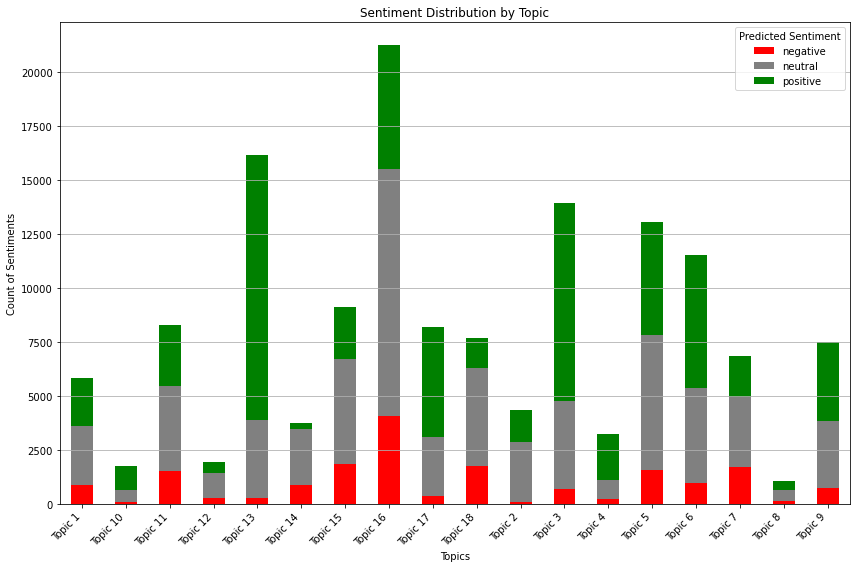

In [134]:
import matplotlib.pyplot as plt

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Create stacked bar chart
grouped_results.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Topics')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution by Topic')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Predicted Sentiment')
plt.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()

### Topic Sentiment Over Time

In [137]:
# Convert 'date' column to datetime
cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])

#### Topic 1: Financial Markets and AI

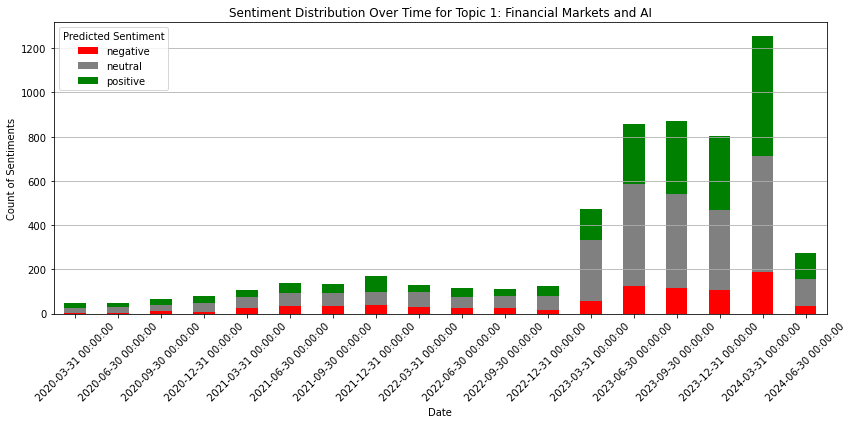

In [142]:
# Filter the DataFrame for a specific topic (e.g., 'Topic 1')
topic_df = cleaned_df[cleaned_df['topic'] == 'Topic 1']

# Group by month and sentiment, then count occurrences
sentiment_over_time = topic_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution Over Time for Topic 1: Financial Markets and AI')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()

#### Topic 2: Technology and Consumer Services

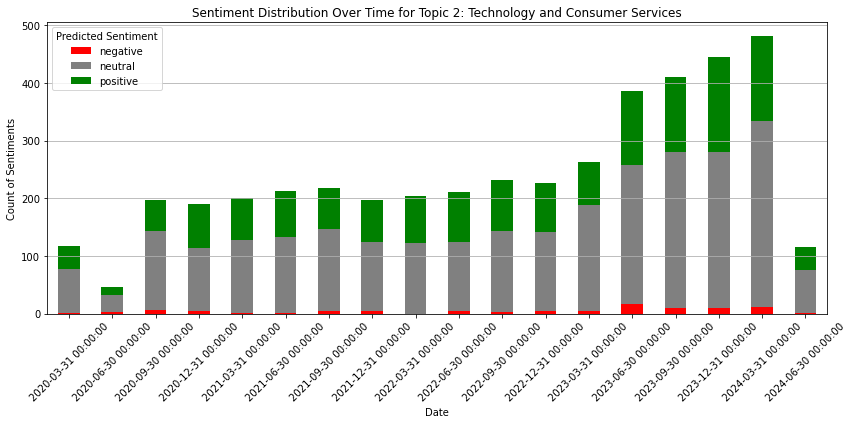

In [141]:
topic_df = cleaned_df[cleaned_df['topic'] == 'Topic 2']

# Group by month and sentiment, then count occurrences
sentiment_over_time = topic_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution Over Time for Topic 2: Technology and Consumer Services')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()

#### Topic 3: Generative AI and Media

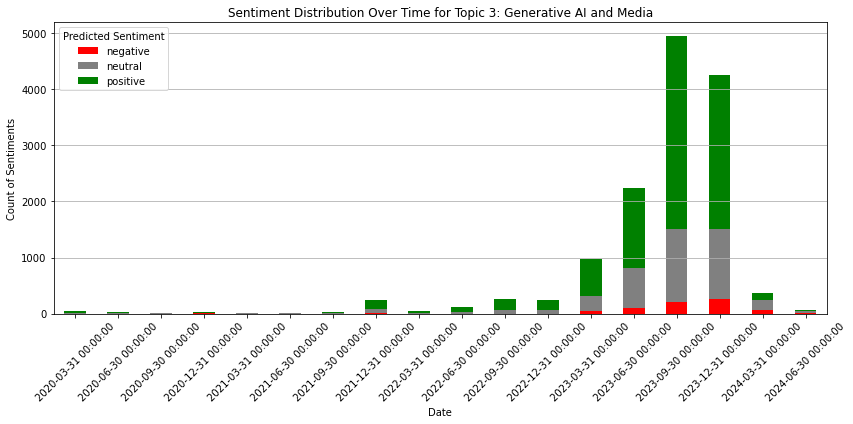

In [143]:
topic_df = cleaned_df[cleaned_df['topic'] == 'Topic 3']

# Group by month and sentiment, then count occurrences
sentiment_over_time = topic_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution Over Time for Topic 3: Generative AI and Media')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()

#### Topic 4: Healthcare and Medical News

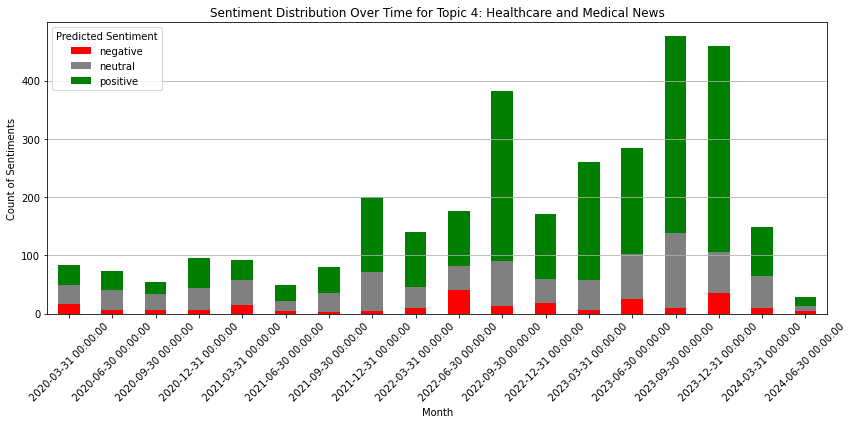

In [144]:
topic_df = cleaned_df[cleaned_df['topic'] == 'Topic 4']

# Group by month and sentiment, then count occurrences
sentiment_over_time = topic_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Month')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution Over Time for Topic 4: Healthcare and Medical News')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()

#### Topic 5: Artificial Intelligence Research

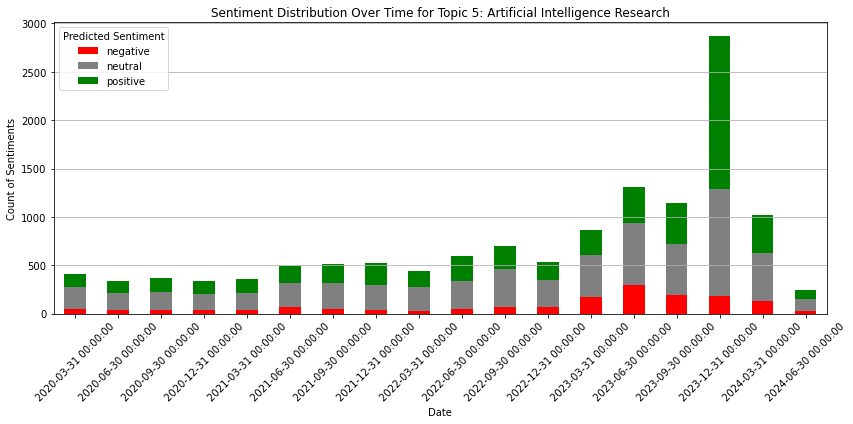

In [145]:
topic_df = cleaned_df[cleaned_df['topic'] == 'Topic 5']

# Group by month and sentiment, then count occurrences
sentiment_over_time = topic_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution Over Time for Topic 5: Artificial Intelligence Research')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()

#### Topic 6: Business and Digital Security

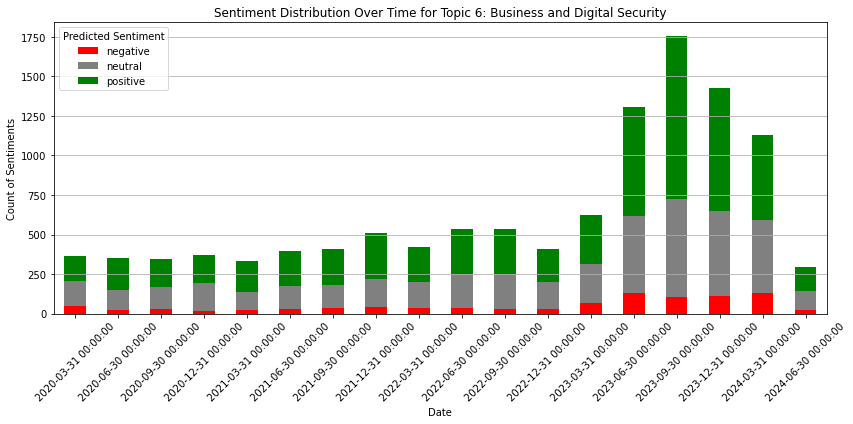

In [146]:
topic_df = cleaned_df[cleaned_df['topic'] == 'Topic 6']

# Group by month and sentiment, then count occurrences
sentiment_over_time = topic_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution Over Time for Topic 6: Business and Digital Security')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()

#### Topic 7: AI and Tech Companies

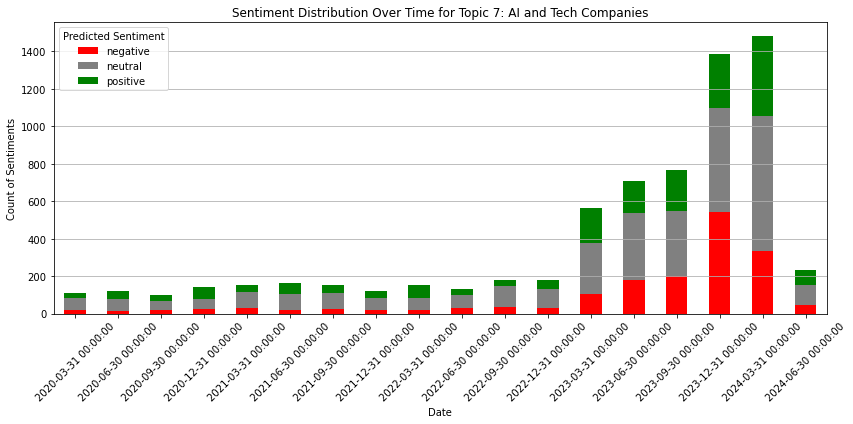

In [147]:
topic_df = cleaned_df[cleaned_df['topic'] == 'Topic 7']

# Group by month and sentiment, then count occurrences
sentiment_over_time = topic_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution Over Time for Topic 7: AI and Tech Companies')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()

#### Topic 8: Digital Communications

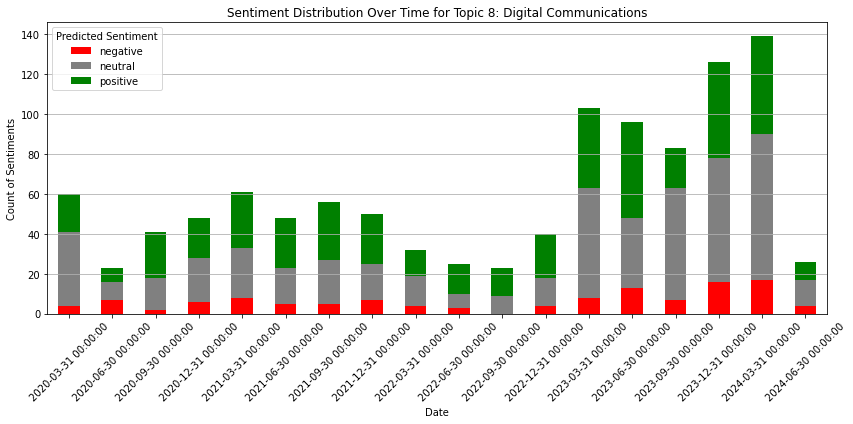

In [148]:
topic_df = cleaned_df[cleaned_df['topic'] == 'Topic 8']

# Group by month and sentiment, then count occurrences
sentiment_over_time = topic_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution Over Time for Topic 8: Digital Communications')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()

#### Topic 9: Data Science and Machine Learning

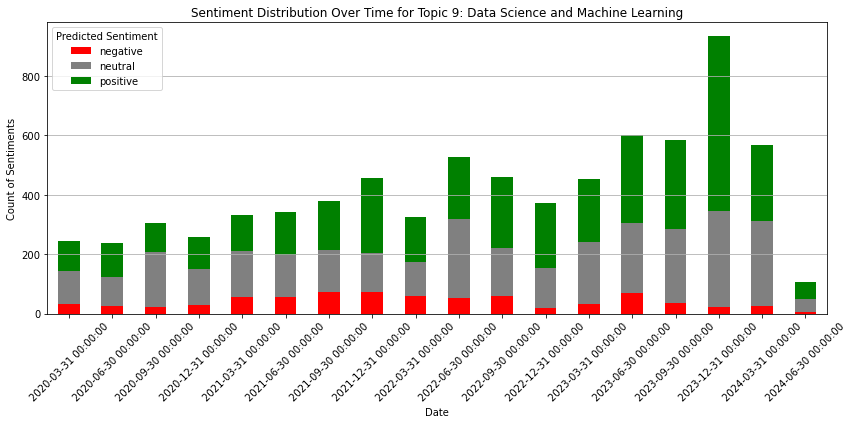

In [149]:
topic_df = cleaned_df[cleaned_df['topic'] == 'Topic 9']

# Group by month and sentiment, then count occurrences
sentiment_over_time = topic_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution Over Time for Topic 9: Data Science and Machine Learning')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()

#### Topic 10: Regional News and Industry Updates

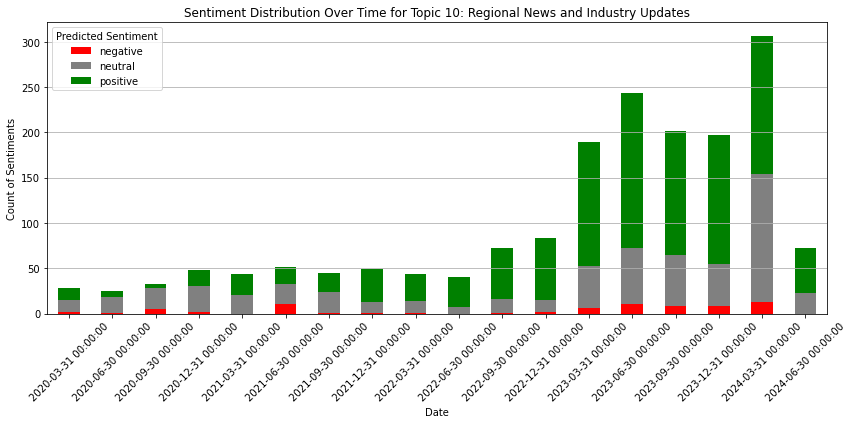

In [150]:
topic_df = cleaned_df[cleaned_df['topic'] == 'Topic 10']

# Group by month and sentiment, then count occurrences
sentiment_over_time = topic_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution Over Time for Topic 10: Regional News and Industry Updates')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()

#### Topic 11: India and Global Technology News

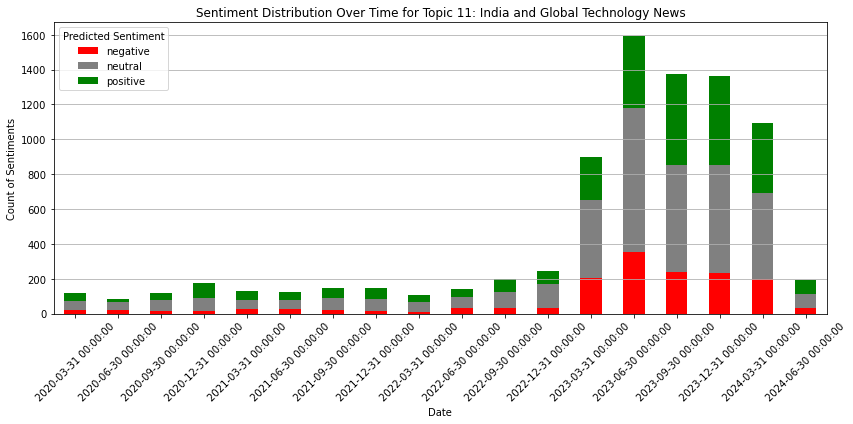

In [151]:
topic_df = cleaned_df[cleaned_df['topic'] == 'Topic 11']

# Group by month and sentiment, then count occurrences
sentiment_over_time = topic_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution Over Time for Topic 11: India and Global Technology News')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()

#### Topic 12: Online Accounts and Social Media

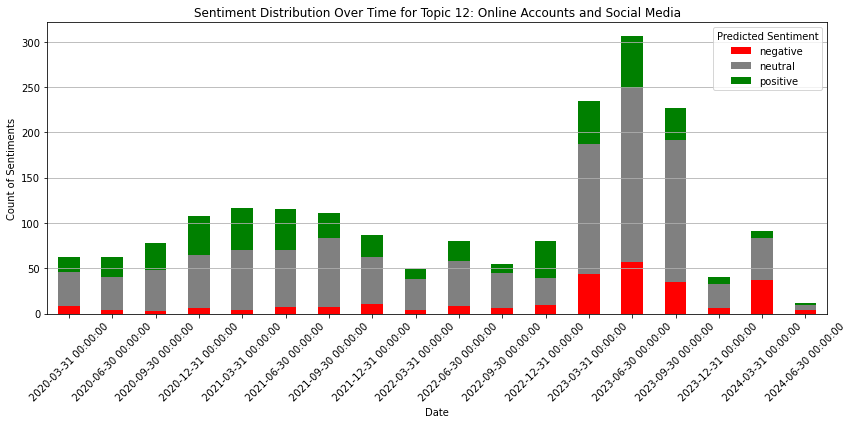

In [152]:
topic_df = cleaned_df[cleaned_df['topic'] == 'Topic 12']

# Group by month and sentiment, then count occurrences
sentiment_over_time = topic_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution Over Time for Topic 12: Online Accounts and Social Media')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()

#### Topic 13: Media Releases and Technology Platforms

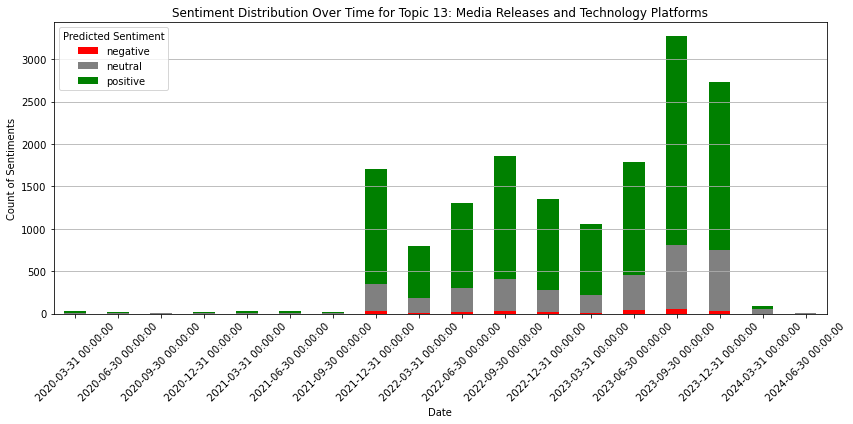

In [153]:
topic_df = cleaned_df[cleaned_df['topic'] == 'Topic 13']

# Group by month and sentiment, then count occurrences
sentiment_over_time = topic_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution Over Time for Topic 13: Media Releases and Technology Platforms')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()

#### Topic 14: Music and Public Radio

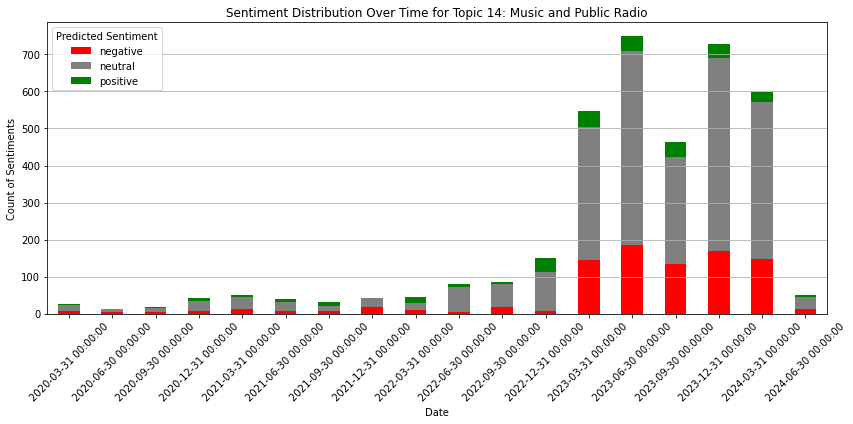

In [154]:
topic_df = cleaned_df[cleaned_df['topic'] == 'Topic 14']

# Group by month and sentiment, then count occurrences
sentiment_over_time = topic_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution Over Time for Topic 14: Music and Public Radio')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()

#### Topic 15: AI and Mobile Technology

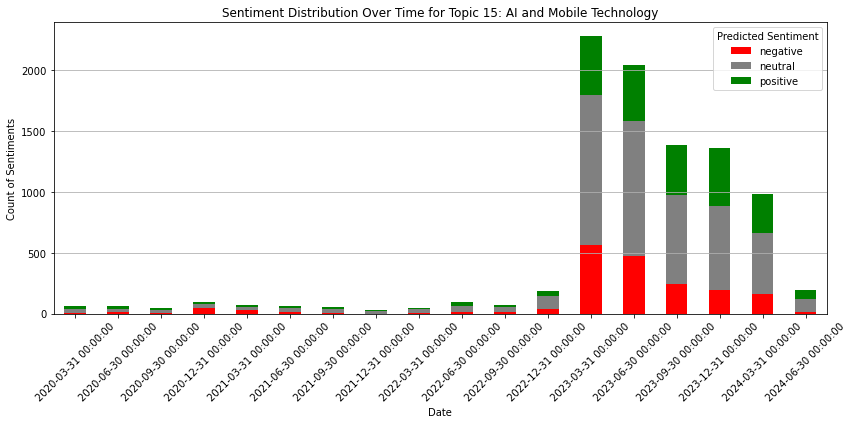

In [155]:
topic_df = cleaned_df[cleaned_df['topic'] == 'Topic 15']

# Group by month and sentiment, then count occurrences
sentiment_over_time = topic_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution Over Time for Topic 15: AI and Mobile Technology')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()

#### Topic 16: General AI and Technology News

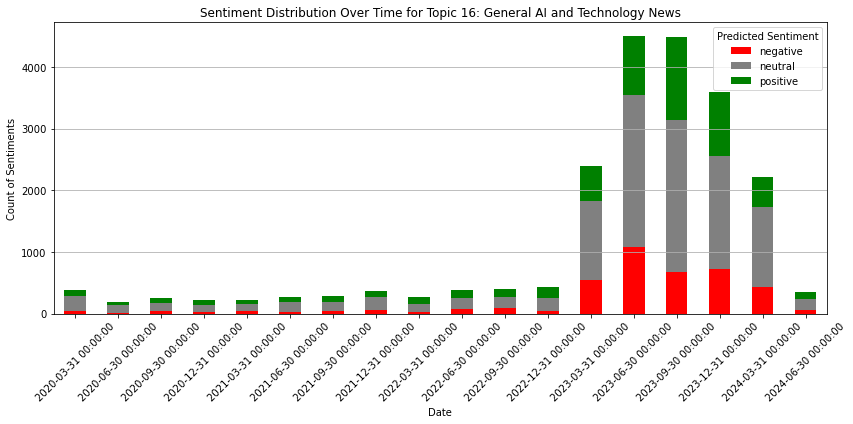

In [156]:
topic_df = cleaned_df[cleaned_df['topic'] == 'Topic 16']

# Group by month and sentiment, then count occurrences
sentiment_over_time = topic_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution Over Time for Topic 16: General AI and Technology News')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()

#### Topic 17: Market Research and Forecasts

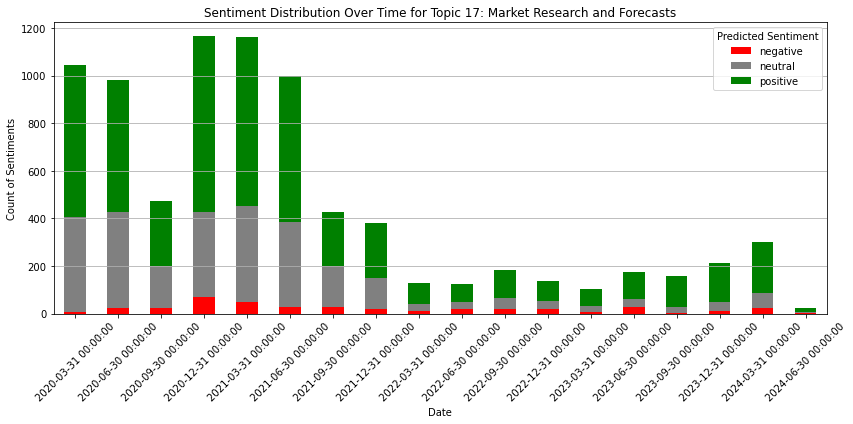

In [157]:
topic_df = cleaned_df[cleaned_df['topic'] == 'Topic 17']

# Group by month and sentiment, then count occurrences
sentiment_over_time = topic_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution Over Time for Topic 17: Market Research and Forecasts')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()

#### Topic 18: General News and Weather Updates

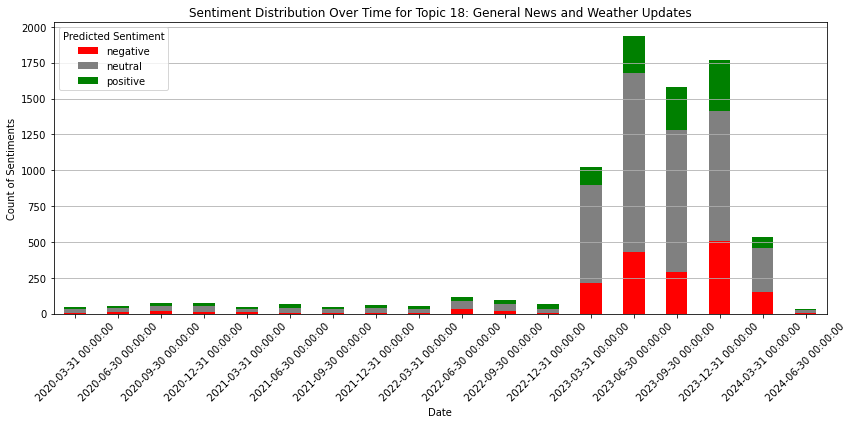

In [158]:
topic_df = cleaned_df[cleaned_df['topic'] == 'Topic 18']

# Group by month and sentiment, then count occurrences
sentiment_over_time = topic_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Count of Sentiments')
plt.title('Sentiment Distribution Over Time for Topic 18: General News and Weather Updates')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()

#### General Sentiment Over Time

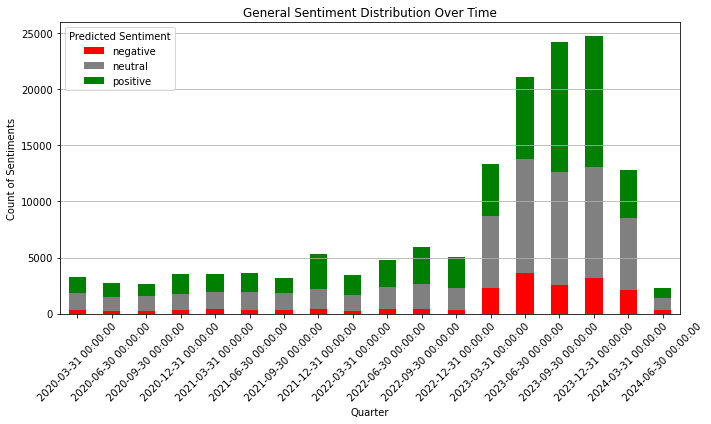

In [159]:
# Group by quarter and sentiment, then count occurrences
sentiment_over_time = cleaned_df.groupby([pd.Grouper(key='date', freq='Q'), 'predicted_sentiment']).size().unstack(fill_value=0)

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create stacked bar chart
sentiment_over_time.plot(kind='bar', stacked=True, ax=ax, color=['red', 'gray', 'green'])

# Customizing the plot
plt.xlabel('Quarter')
plt.ylabel('Count of Sentiments')
plt.title('General Sentiment Distribution Over Time')
plt.legend(title='Predicted Sentiment')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()